In [ ]:
from importlib import  reload
import sys
from imp import  reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
  reload(sys)
  sys.setdefaultencoding("utf-8")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def read_data(filename):
  file_content = pd.read_excel(filename)
  return file_content

train_data = read_data('train_data_offensive_language_marathi_updated.xlsx')
test_data = read_data('test_data_offensive_language_marathi_updated.xlsx')
train_data['Class'] = train_data['Class'].map({'not offensive': 1, 'offensive': 0})
test_data['Class'] = test_data['Class'].map({'not offensive': 1, 'offensive': 0})
X_train, X_valid, Y_train, Y_valid = train_data.Tweet, test_data.Tweet, train_data.Class, test_data.Class

In [ ]:
type(Y_train[0])

numpy.int64

In [ ]:
MAX_FEATURES = 3000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True,split=' ')
tokenizer.fit_on_texts(train_data['Tweet'].values)
list_tokenized_train = tokenizer.texts_to_sequences(train_data['Tweet'].values)
  
RNN_CELL_SIZE = 32
MAX_LEN = 300  

X_train = pad_sequences(list_tokenized_train)

X_valid = tokenizer.texts_to_sequences(test_data['Tweet'].values)
X_valid = pad_sequences(X_valid)

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     384000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 300, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 300, 64), (N 24832       bi_lstm_0[0][0]                  
_______________________________________________________________________________________

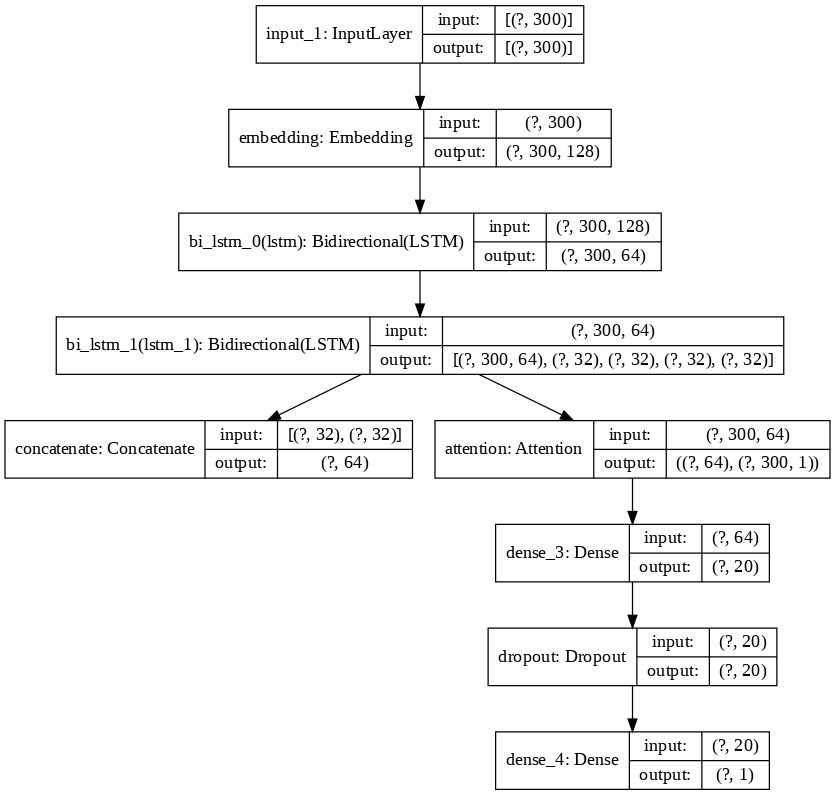

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [ ]:
type(Y_valid[100])

numpy.int64

In [ ]:
BATCH_SIZE = 100
EPOCHS = 3
history = model.fit(X_train,Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/3
15/15 [==============================] - 4s 247ms/step - loss: 0.6697 - tp: 957.0000 - fp: 542.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.6384 - precision: 0.6384 - recall: 1.0000 - auc: 0.4756 - val_loss: 0.6400 - val_tp: 248.0000 - val_fp: 127.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6613 - val_precision: 0.6613 - val_recall: 1.0000 - val_auc: 0.5367
Epoch 2/3
15/15 [==============================] - 1s 89ms/step - loss: 0.6464 - tp: 957.0000 - fp: 542.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.6384 - precision: 0.6384 - recall: 1.0000 - auc: 0.6176 - val_loss: 0.6225 - val_tp: 248.0000 - val_fp: 127.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6613 - val_precision: 0.6613 - val_recall: 1.0000 - val_auc: 0.7878
Epoch 3/3
15/15 [==============================] - 1s 86ms/step - loss: 0.5050 - tp: 940.0000 - fp: 386.0000 - tn: 156.0000 - fn: 17.0000 - accuracy: 0.7312 - precision: 0.7089 - recall: 0.9822 - auc: 0.

In [ ]:
prediction = model.predict(X_valid)
y_pred = (prediction > 0.5)

              precision    recall  f1-score   support

           0     0.7524    0.7488    0.7506       207
           1     0.8759    0.8780    0.8769       418

    accuracy                         0.8352       625
   macro avg     0.8142    0.8134    0.8138       625
weighted avg     0.8350    0.8352    0.8351       625



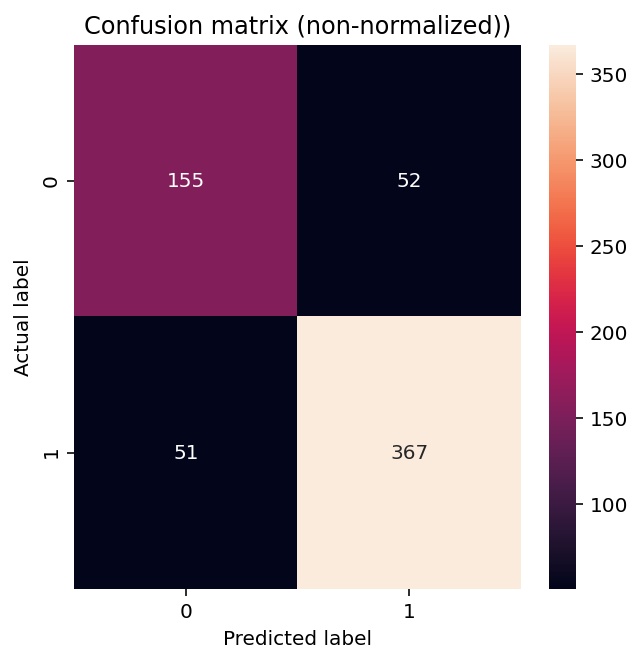

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(Y_valid, y_pred, digits=4)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(Y_valid, y_pred)